## **Offline surrogate map-elites**

# Preprocess data

In [ ]:

%pip install tqdm
%pip install tensorflow_addons
%pip install ipympl
%pip install pandas
%pip install sklearn
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import json
from IPython import display
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from itertools import combinations
from tqdm import tqdm
import ipympl
import time


: 

In [2]:
tf.config.list_physical_devices('GPU')

2022-08-23 13:08:05.665386: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 13:08:05.669663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 13:08:05.805870: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-23 13:08:05.805908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2022-08-23 13:08:05.805960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-23 13:08:05.806994: I tensorflow/stream_executor/platfo

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

ave been built without NUMA support.
2022-08-23 13:08:05.813125: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-23 13:08:05.813136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0


Load simulation data from google sheets

In [3]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQQjntJiCUHUFAxlIwg8up-MMquUNfarDIZQPEfunP5S0Yr2qco8M0Om6XANEyJChS-aABMBsxnqv7n/pub?gid=1113108314&single=true&output=csv')

Get matchups from other players perspectives

In [4]:
flipped_data = data[['enemy', 'player', 'health', 'winrate']]
flipped_data.rename({'enemy': 'player', 'player': 'enemy'}, axis=1, inplace=True)
flipped_data['health'] = flipped_data['health'].apply(lambda x: x * -1)
flipped_data['winrate'] = flipped_data['winrate'].apply(lambda x: 1 - x)

In [5]:
combined = pd.concat([data, flipped_data], axis=0, ignore_index=True)


Split decks to bag of cards

In [6]:
card_details = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQQjntJiCUHUFAxlIwg8up-MMquUNfarDIZQPEfunP5S0Yr2qco8M0Om6XANEyJChS-aABMBsxnqv7n/pub?gid=468949505&single=true&output=csv')

In [7]:
player_bag = combined['player'].astype(str).apply(lambda x: pd.Series(list(x))).astype(int)
enemy_bag  = combined['enemy'].astype(str).apply(lambda x: pd.Series(list(x))).astype(int)


In [8]:
simulations = pd.concat([combined[['health', 'winrate']], player_bag, enemy_bag], axis=1, ignore_index=True)

player_card_names = [f"p {card_name}" for card_name in card_details['name']]
enemy_card_names = [f"e {card_name}" for card_name in card_details['name']]
simulations.columns = ['health', 'winrate'] + player_card_names + enemy_card_names

# Train regression model

In [9]:
sample = simulations.copy()
winrate = sample['winrate']
health = sample['health']
sample = sample.drop('winrate', axis=1)
sample = sample.drop('health', axis=1)

X_train, X_test, y_train, y_test = train_test_split(sample, winrate, random_state=1)


In [10]:
model = tf.keras.Sequential([tf.keras.layers.Dense(512, activation='relu', input_dim=306),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1, activation='relu'),

                             ])

model.summary()

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mse', tfa.metrics.r_square.RSquare()])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_r_square', patience=2)

history = model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[stop_early])

Epoch 1/30
1258/1258 [==============================] - 5s 3ms/step - loss: 0.0077 - mse: 0.0077 - r_square: 0.8004 - val_loss: 0.0053 - val_mse: 0.0053 - val_r_square: 0.8605
Epoch 2/30
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0047 - mse: 0.0047 - r_square: 0.8794 - val_loss: 0.0051 - val_mse: 0.0051 - val_r_square: 0.8659
Epoch 3/30
1258/1258 [==============================] - 4s 3ms/step - loss: 0.0036 - mse: 0.0036 - r_square: 0.9064 - val_loss: 0.0048 - val_mse: 0.0048 - val_r_square: 0.8735


<AxesSubplot:title={'center':'Regressor loss'}>

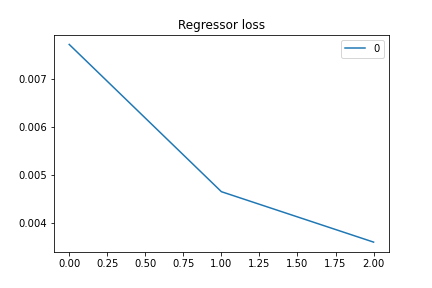

In [ ]:
history_df = pd.DataFrame(history.history['loss'])
history_df.plot(title='Regressor loss')

## Map elites archive class

In [ ]:
class Archive():
  def __init__(self, x_range, y_range, num_buckets=10):
    self.num_buckets = num_buckets
    self.x_bin_ranges = []
    self.y_bin_ranges = []
    self.x_min, self.x_max = x_range
    self.y_min, self.y_max = y_range
    self.bins = [[{"x": x, "y": y, "fitness": None, "sample": pd.Series(dtype='float64')} for x in range(self.num_buckets)] for y in range(self.num_buckets)] 
    
    for i in range(num_buckets):
      self.x_bin_ranges.append(self.x_min+(i/num_buckets)*(self.x_max-self.x_min))
      self.y_bin_ranges.append(self.y_min+(i/num_buckets)*(self.y_max-self.y_min))

  def val_to_bin_index(self, value, dimension):
    if dimension == 0:
      for index, x in enumerate(self.x_bin_ranges):
        if value < x:
          return index-1
      return len(self.x_bin_ranges)-1
    elif dimension == 1:
      for index, y in enumerate(self.y_bin_ranges):
        if value < y:
          return index-1
      return len(self.y_bin_ranges)-1
    
  def add_sample(self, x, y, fitness, sample):
    x_index = self.val_to_bin_index(x, 0)
    y_index = self.val_to_bin_index(y, 1)

    bin_fitness = self.bins[x_index][y_index]['fitness']
    if bin_fitness == None or bin_fitness < fitness:
      self.bins[x_index][y_index]['fitness'] = fitness
      self.bins[x_index][y_index]['sample'] = sample

  def clear(self):
    self.bins = [[{"x": x, "y": y, "fitness": None, "sample": pd.Series()} for x in range(self.num_buckets)] for y in range(self.num_buckets)] 

  def get_elites(self, num_to_get=-1):
    all_elites = []
    for row in self.bins:
      for elite in row:
        if(elite['fitness'] != None):
          all_elites.append(elite)
    if num_to_get == -1:
      return all_elites
    else:
      random.shuffle(all_elites)
      return all_elites[:num_to_get]

  def get_bins(self):
    all_bins = []
    for row in self.bins:
      for elite in row:
        all_bins.append({'x': elite['x'], 'y': elite['y'],\
                         'fitness': elite['fitness'], \
                         'sample': elite['sample']})
    return all_bins
  
  def get_bins_as_string(self):
    all_bins = []
    for row in self.bins:
      for elite in row:
        
        all_bins.append({'x': elite['x'], 'y': elite['y'],\
                         'fitness': str(elite['fitness']), \
                         'sample': elite['sample'].to_json()})
    return all_bins

  def get_most_fit(self):
    return max(self.get_elites(), key = lambda x: x['fitness'])
  
  def get_average_fitness(self):
    fitnesses = [elite['fitness'] for elite in self.get_elites()]
    return mean(fitnesses)

  def get_random(self):
    return random.choice(self.get_elites())

  def display(self, ax, fig, attribute_to_display='fitness'):
    #%matplotlib widget
    #%matplotlib inline
    z = [[el[attribute_to_display] if el[attribute_to_display] != None else np.nan for el in row] for row in self.bins]
    x = self.x_bin_ranges
    y = self.y_bin_ranges
    Zm = ma.masked_invalid(z)

    
    if attribute_to_display == 'winrate':
      im = ax.pcolormesh(x, y, Zm.T[:-1, :-1], vmin=0, vmax=1, shading='flat')
    else:
      im = ax.pcolormesh(x, y, Zm.T[:-1, :-1], vmin=0, vmax=1, shading='flat')
    fig.colorbar(im, ax=ax)
    # ax.set_xticks(range(0,11))
    # ax.set_yticks(range(0,21,2))
    ax.set_xlabel('Mean mana-cost')
    ax.set_ylabel('Mana-cost variance')



  def save_as_json(self):
    with open('data/map_archive.json', 'w', encoding='utf-8') as f:
      archive_bins_as_bag = self.get_bins_as_string()
      json.dump(archive_bins_as_bag, f, ensure_ascii=False)

  def save_as_pickle(self):
    with open('data/map_archive.pkl', 'wb') as f:
      pickle.dump(self, f)


# Utility functions

In [ ]:
def generate_random_deck():
  rand_deck = pd.Series(0.0, index=range(153))
  for index, num in random.sample(list(enumerate(rand_deck)), 15):
    rand_deck[index] = 1.0
  return rand_deck


In [ ]:
def generate_matchup(player_deck, enemy_deck):
  matchup = pd.concat([player_deck, enemy_deck])
  matchup.index=player_card_names+enemy_card_names
  matchup = matchup.to_frame().T
  return matchup


In [ ]:
def perturb_deck(deck):

  rand = random.random()
  for exponent in range(6):
    if rand < 1/(2**exponent):
      num_swaps = exponent + 5

  cards_in_deck = [(index, card) for index, card in enumerate(deck) if card == 1.0]
  cards_not_in_deck = [(index, card) for index, card in enumerate(deck) if card == 0.0]

  for index, removed_card in random.sample(cards_in_deck, num_swaps):
    deck[index] = 0.0
  for index, removed_card in random.sample(cards_not_in_deck, num_swaps):
    deck[index] = 1.0
  return deck

# test_deck = generate_random_deck()
# for index, card in enumerate(test_deck):
#   if card == 1.0:
#     print(index)
# test_deck = perturb_deck(test_deck)
# for index, card in enumerate(test_deck):
#   if card == 1.0:
#     print(index)

In [ ]:
from statistics import mean, variance
def get_mana_stats(deck):
  mana_costs = []  
  for index, count in enumerate(deck):
    if count == 1.0:
      mana_costs.append(float(card_details['mana'][index]))
  return (mean(mana_costs), variance(mana_costs))



In [ ]:
def get_matchups(population, matchup_size):
  random.shuffle(population)
  matchups = []
  
  for skip_size in range(matchup_size):
    for index, player in enumerate(population):
      enemy = population[(index+skip_size)%len(population)]
      matchups.append((player, enemy))
  return matchups

In [ ]:
def convert_decklist_to_bag(decklist):
  deck_as_bag = pd.Series(0.0, index=range(153))

  for card in decklist:
    index = card_details.loc[card_details['name'] == card].index[0]
    deck_as_bag[index] = 1.0

  return deck_as_bag


In [ ]:
def convert_bag_to_decklist(bag):
  deck_as_list = []

  for index, count in enumerate(bag):
    if count == 1.0:
      deck_as_list.append(card_details['name'][index])

  return deck_as_list

In [ ]:
def test_decklist(decklist):
  decklist = convert_decklist_to_bag(decklist)
  fitnesses = []
  for i in range(100):
    enemy = generate_random_deck()
    matchup = generate_matchup(decklist, enemy)
    # matchup = np.asarray(matchup).astype('float32')
    fitnesses.append(model.predict(matchup, verbose=0)[0][0])

  return mean(fitnesses)


## Test decks

In [ ]:
basic_hunter = ['Arcane Shot',
'Stonetusk Boar',
'Timber Wolf',
'Tracking',
'Bloodfen Raptor',
'River Crocolisk',
'Ironforge Rifleman',
'Raid Leader',
'Razorfen Hunter',
'Silverback Patriarch',
'Houndmaster',
'Multi-Shot',
'Oasis Snapjaw',
'Stormpike Commando',
'Core Hound']


test_decklist(basic_hunter)

0.56887877

In [ ]:
#https://hearthstone-decks.net/face-hunter-338-legend-risewashere_hs-score-47-21/

meta_face_hunter = ['Abusive Sergeant',
                    'Arcane Shot',
                    'Argent Squire',
                    'Leper Gnome',
                    'Tracking',
                    'Worgen Infiltrator',
                    'Explosive Trap',
                    'Knife Juggler',
                    'Misdirection',
                    'Animal Companion',
                    'Arcane Golem',
                    'Eaglehorn Bow',
                    'Kill Command',
                    'Unleash the Hounds',
                    'Wolfrider']

test_decklist(meta_face_hunter)

0.8318948

In [ ]:
basic = convert_decklist_to_bag(basic_hunter)
meta = convert_decklist_to_bag(meta_face_hunter)

model.predict(generate_matchup(meta, basic))

1/1 [==============================] - 0s 12ms/step


array([[0.77581275]], dtype=float32)

# Map elites

Initial population of random decks

In [ ]:
def surrogate_map_elites_initial_population():
  map_archive = Archive((1, 6), (0, 20), num_buckets=20)

  population = [{'index': index, 'deck': generate_random_deck(), 'fitness': 0} for index, deck_index in enumerate(range(population_size))]

  matchups = get_matchups(population, matchup_size)

  # for player, enemy in tqdm(matchups):
  #   fitness = model.predict(generate_matchup(player['deck'], enemy['deck']))[0][0]
  #   population[player['index']]['fitness'] += fitness / (matchup_size*2)
  #   population[enemy['index']]['fitness'] += fitness / (matchup_size*2)
  for player in population:
    fitness = model.predict(generate_matchup(player['deck'], meta), verbose=0)[0][0]
    population[player['index']]['fitness'] = fitness

  for player in population:
    mana_mean, mana_variance = get_mana_stats(player['deck'])
    map_archive.add_sample(mana_mean, mana_variance, player['fitness'], player['deck'])

  return map_archive

Iterativly perturb elites for next generation

In [ ]:
def surrogate_map_elites_iteration(map_archive, fitness_history, fitness_average_history):
  population = [{'index': index, 'deck': perturb_deck(elite['sample']), 'fitness': 0} for index, elite in enumerate(map_archive.get_elites(num_to_get = max_elites))]

  matchups = get_matchups(population, matchup_size)

  # for player, enemy in matchups:
  #   fitness = model.predict(generate_matchup(player['deck'], enemy['deck']))[0][0]
  #   population[player['index']]['fitness'] += fitness / (matchup_size*2)
  #   population[enemy['index']]['fitness'] += fitness / (matchup_size*2)
  for player in population:

    fitness = model.predict(generate_matchup(player['deck'], meta), verbose=0)[0][0]
    population[player['index']]['fitness'] = fitness

  for player in population:
    mana_mean, mana_variance = get_mana_stats(player['deck'])
    map_archive.add_sample(mana_mean, mana_variance, player['fitness'], player['deck'])

  fitness_history.append(map_archive.get_most_fit()['fitness'])
  fitness_average_history.append(map_archive.get_average_fitness())



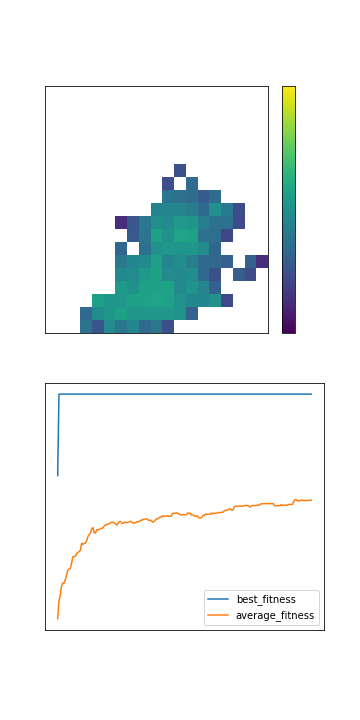

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


In [ ]:
population_size = 100
matchup_size = 100
max_elites = 120
num_iterations = 1
load_from_pickle = True


if load_from_pickle:
  with open('data/map_archive.pkl', 'rb') as pickled_archive:
    map_archive = pickle.load(pickled_archive)
  with open('data/fitness_history.pkl', 'rb') as fitness_history_pickle:
    fitness_history = pickle.load(fitness_history_pickle)
  with open('data/fitness_average_history.pkl', 'rb') as fitness_average_history_pickle:
    fitness_average_history = pickle.load(fitness_average_history_pickle)
else:
  map_archive = surrogate_map_elites_initial_population()
  fitness_history = []
  fitness_average_history = []


for i in tqdm(range(num_iterations)):
  surrogate_map_elites_iteration(map_archive, fitness_history, fitness_average_history)

  fitness_combined = pd.concat([pd.DataFrame(fitness_history), pd.DataFrame(fitness_average_history)], axis=1)
  fitness_combined.columns = ['best_fitness', 'average_fitness']

  fig, axs = plt.subplots(2, figsize=(5, 10), gridspec_kw={'height_ratios': [1, 1]})

  map_archive.display(axs[0], fig, 'fitness')

  fitness_combined.plot(kind='line', ax=axs[1])
  display.clear_output(wait=True)
  plt.rcParams.update({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', 'legend.labelcolor': 'black'})
  plt.show()
  

  with open('data/fitness_history.pkl', 'wb') as fitness_history_pickle:
    pickle.dump(fitness_history, fitness_history_pickle)
  with open('data/fitness_average_history.pkl', 'wb') as fitness_average_history_pickle:
    pickle.dump(fitness_average_history, fitness_average_history_pickle)
  map_archive.save_as_pickle()

In [ ]:
most_fit = map_archive.get_most_fit()

print(f"Fitness: {most_fit['fitness']}")
convert_bag_to_decklist(most_fit['sample'])

: 

In [ ]:
print(len(map_archive.get_elites()))